# Fraud ETL

- Create a profile of individual user's spending behavior
- Fraudulent transactions may be more likely to have high amounts
- TransactionDT is "timestamp"; add dollar/time as a metric, if it's high then that means someone is withdrawing more money than their past activity suggests that they need
- Recipient email could look suspicious or be different from usual

## Data descriptions

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features: ProductCD card1 - card6 addr1, addr2 P_emaildomain R_emaildomain M1 - M9

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xgboost

In [2]:
base = Path('/home/zach/datasets/ieee-fraud-detection')
train = pd.read_csv(base / 'train_transaction.csv')

# test = pd.read_csv(base / 'test_transaction.csv')
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
counts = train['isFraud'].value_counts()
counts[1] / (counts[0] + counts[1])

np.float64(0.03499000914417313)

In [12]:
# Baseline performance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

categorical_cols = train.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    train[col] = encoder.fit_transform(train[col].astype(str))


def test_baseline(X_train, y_train, X_test, y_test, fraud_rate=0.03499):
    classifier = xgboost.XGBClassifier(eval_metric='logloss')

    classifier.fit(X_train, y_train)
    y_pred_proba = classifier.predict_proba(X_test)

    # 3.499% of train transactions are fraud, so we will label top 3.5% of test transactions as fraud
    top_k = int(fraud_rate * len(y_pred_proba))
    top_k_index = pd.Series(y_pred_proba[:, 1]).sort_values(ascending=False).index[:top_k]
    y_pred = [1 if i in top_k_index else 0 for i in range(len(y_test))]

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')

    return classifier

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop(['isFraud', 'TransactionID'], axis=1), train['isFraud'], test_size=0.2, random_state=42)
test_baseline(X_train, y_train, X_test, y_test)

Accuracy: 0.9763
F1 Score: 0.6651


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

## Resampling for imbalanced datasets

Because `test_baseline` includes a `train_test_split`, there is data leakage when using oversampling, which likely explains its high accuracy. Since there are N copies of each instance of fraud and `train_test_split` randomly splits data into the training and testing DataFrames, there are probably going to be identical instances in both the training and testing splits.

Update: removed `train_test_split` from `test_baseline`.

Fraud: 16538, Not Fraud: 455894


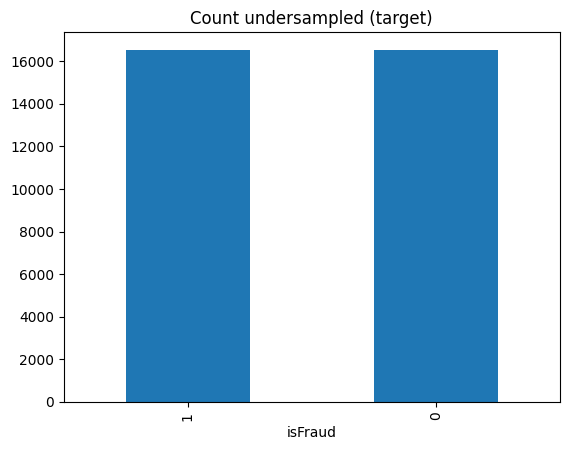

Undersampled baseline:
Accuracy: 0.9711
F1 Score: 0.5860


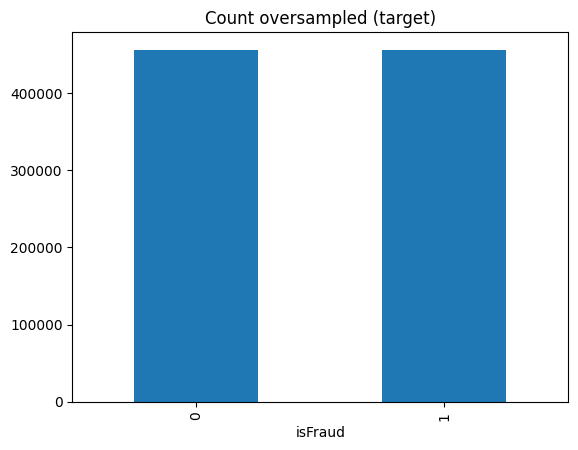

Oversampled baseline:
Accuracy: 0.9739
F1 Score: 0.6262


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [13]:
# Undersampling and oversampling

# Split all data into train/test to preserve label distribution
df_undersample_train = train.sample(frac=0.8, random_state=42)
df_undersample_test = train.drop(df_undersample_train.index)

# Undersample only train entries
df_fraud = df_undersample_train[df_undersample_train['isFraud'] == 1]
df_not_fraud = df_undersample_train[df_undersample_train['isFraud'] == 0]

count_not_fraud, count_fraud = df_undersample_train['isFraud'].value_counts()
print(f'Fraud: {count_fraud}, Not Fraud: {count_not_fraud}')

undersampled = pd.concat([df_fraud, df_not_fraud.sample(count_fraud, random_state=42)], axis=0)
undersampled['isFraud'].value_counts().plot(kind='bar', title='Count undersampled (target)')
plt.show()

X_undersample_train = undersampled.drop(['isFraud', 'TransactionID'], axis=1)
y_undersample_train = undersampled['isFraud']

X_undersample_test = df_undersample_test.drop(['isFraud', 'TransactionID'], axis=1)
y_undersample_test = df_undersample_test['isFraud']

fraud_rate = df_undersample_train['isFraud'].mean()

print('Undersampled baseline:')
test_baseline(X_undersample_train, y_undersample_train, X_undersample_test, y_undersample_test, fraud_rate=fraud_rate)

# To reduce label leakage, we should perform oversampling after the train-test split
oversample_train = train.sample(frac=0.8, random_state=42)
oversample_test = train.drop(oversample_train.index)

# These test entries will not be oversampled
X_oversample_test = oversample_test.drop(['isFraud', 'TransactionID'], axis=1)
y_oversample_test = oversample_test['isFraud']

oversample_df_fraud = oversample_train[oversample_train['isFraud'] == 1]
oversample_df_not_fraud = oversample_train[oversample_train['isFraud'] == 0]

oversample_count_not_fraud = oversample_df_not_fraud.shape[0]

# Oversample the fraud class in training data
oversampled = pd.concat([oversample_df_not_fraud, oversample_df_fraud.sample(oversample_count_not_fraud, replace=True, random_state=42)], axis=0)
oversampled['isFraud'].value_counts().plot(kind='bar', title='Count oversampled (target)')
plt.show()

X_oversample_train = oversampled.drop(['isFraud', 'TransactionID'], axis=1)
y_oversample_train = oversampled['isFraud']

fraud_rate = oversample_train['isFraud'].mean()

print('Oversampled baseline:')
test_baseline(X_oversample_train, y_oversample_train, X_oversample_test, y_oversample_test, fraud_rate=fraud_rate)

## Assessment of resampling

After accounting for label leakage, oversampling performs significantly better than undersampling in this scenario. As a result, oversampling will be used in the future.

## Predicting labels vs probabilities

When XGBoost trains, it is predicting the underlying distribution of the function `P(y | x)`. In training this distribution is 50/50, but that is not representative of the real-world fradulence rate. As a result, the model loses performance in the testing set. Instead of directly predicting the labels, `model.predict_proba` can be used to return the probabilities of each entry to belong to each class. Although these probabilities are based on a 50/50 distribution, the outputs can be sorted according to their likelihood of being fraud. Then, using the percentage of fraud in the training set, the top N entries can be selected and labeled as fraudulent. This increased oversampled F1 score from 0.4196 to 0.6262. Again, to avoid leakage, the fraud rate is calculated based only on the training set.